In [ ]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.init as init
from torch.autograd import Variable
import argparse
import numpy as np
import time
from PIL import Image
from utils.dataloader import *
#from utils.auc_all_class import * 
#fom utils.auc_test import *
from utils import new_transforms
from matplotlib import *
from pylab import *
from utils.dataloader import *




In [2]:
imgSize = 299
transform = transforms.Compose([new_transforms.Resize((imgSize,imgSize)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
def get_tile_probability(tile_path):

    """
    Returns an array of probabilities for each class given a tile
    @param tile_path: Filepath to the tile
    @return: A ndarray of class probabilities for that tile
    """

    # Some tiles are empty with no path, return nan
    if tile_path == '':
        return np.full(num_classes, np.nan)

    tile_path = root_dir + tile_path

    with open(tile_path, 'rb') as f:
        with Image.open(f) as img:
            img = img.convert('RGB')

    # Model expects a 4D tensor, unsqueeze first dimension
    img = transform(img).unsqueeze(0)
    img = img.cuda()

    # Turn output into probabilities with softmax
    var_img = Variable(img, volatile=True)
    output = F.softmax(model(var_img)).data.squeeze(0)

    return output.cpu().numpy()

#with open(tile_dict_path, 'rb') as f:
#    tile_dict = pickle.load(f)



In [4]:
def aggregate(file_list, method):

    """
    Given a list of files, return scores for each class according to the
    method and labels for those files.
    @param file_list: A list of file paths to do predictions on
    @param method: 'average' - returns the average probability score across
                               all tiles for that file
                   'max' - predicts each tile to be the class of the maximum
                           score, and returns the proportion of tiles for
                           each class
    @return: a ndarray of class probabilities for all files in the list
             a ndarray of the labels
    """

    model.eval()
    predictions = []
    true_labels = []

    for file in file_list:
        tile_paths, label = tile_dict[file]
        print(tile_paths)
        print(label)

        folder = classes[label]

        def add_folder(tile_path):
            if tile_path == '':
                return ''
            else:
                return folder + '/' + tile_path

        # Add the folder for the class name in front
        add_folder_v = np.vectorize(add_folder)
        tile_paths = add_folder_v(tile_paths)

        # Get the probability array for the file
        prob_v = np.vectorize(get_tile_probability, otypes=[np.ndarray])
        probabilities = prob_v(tile_paths)


        """
        imgSize = probabilities.shape()
        newShape = (imgSize[0], imgSize[1], 3)
        probabilities = np.reshape(np.stack(probabilities.flat), newShape)
        """

        if method == 'average':
            probabilities = np.stack(probabilities.flat)
            prediction = np.nanmean(probabilities, axis = 0)

        elif method == 'max':
            probabilities = np.stack(probabilities.flat)
            probabilities = probabilities[~np.isnan(probabilities).all(axis=1)]
            votes = np.nanargmax(probabilities, axis=1)
            
            out = np.array([sum(votes == i) for i in range(num_classes)])
            prediction = out / out.sum()

        else:
            raise ValueError('Method not valid')

        predictions.append(prediction)
        true_labels.append(label)

    return np.array(predictions), np.array(true_labels)

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, pool, **kwargs):
        super(BasicConv2d, self).__init__()

        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.conv(x)

        if self.pool:
            x = F.max_pool2d(x, 2)
        
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        return x

%matplotlib inline

# Define model
class cancer_CNN(nn.Module):
    def __init__(self, nc, imgSize, ngpu):
        super(cancer_CNN, self).__init__()
        self.nc = nc
        self.imgSize = imgSize
        self.ngpu = ngpu
        self.data = 'lung'
        self.conv1 = BasicConv2d(nc, 16, False, kernel_size=5, padding=1, stride=2, bias=True)
        self.conv2 = BasicConv2d(16, 32, False, kernel_size=3, bias=True)
        self.conv3 = BasicConv2d(32, 64, True, kernel_size=3, padding=1, bias=True)
        self.conv4 = BasicConv2d(64, 64, True, kernel_size=3, padding=1, bias=True)
        self.conv5 = BasicConv2d(64, 128, True, kernel_size=3, padding=1, bias=True)
        self.conv6 = BasicConv2d(128, 64, True, kernel_size=3, padding=1, bias=True)
        self.linear = nn.Linear(5184, 3)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x = x6.view(x6.size(0), -1)
        x = self.linear(x)
        return x,x1,x2,x3,x4,x5,x6



In [5]:
model = cancer_CNN(3, imgSize, 1)
model_path = "/scratch/jmw784/capstone/deep-cancer/experiments/train_lung_es/epoch_10.pth"
state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict)


In [6]:
#random
#lusc:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUSC/test_TCGA-18-3410-01A-01-BS1.09c41a54-9a42-4031-ab05-6f955e109ba5_10_4.jpeg'
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUSC/test_TCGA-22-A5C4-01A-01-TS1.B39014C5-A88F-4D6E-8891-FBBD37B85361_131_15.jpeg'
#luad:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUAD/test_TCGA-05-4245-01A-01-TS1.bf71c76b-e802-4a7a-b6c3-c5f46212fab0_10_12.jpeg'
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUAD/test_TCGA-35-5375-01A-01-TS1.27e6fc22-66c0-4d17-981d-2b34a17edd49_33_10.jpeg'
#normal:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/Solid_Tissue_Normal/test_TCGA-18-3410-11A-01-BS1.69eef7c1-1705-4ee6-9d87-d77b0b5062e4_12_16.jpeg'
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/Solid_Tissue_Normal/test_TCGA-22-4593-11A-01-TS1.d201493f-1067-4e6c-84e3-b203f3397a93_5_2.jpeg'


#high probability , >0.99
#lusc:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUSC/test_TCGA-98-A53A-01A-01-TS1.EADCFE65-613A-4C37-A034-C5B11D452D4F_70_10.jpeg'
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUSC/test_TCGA-85-8276-01A-01-TS1.2148c209-f5b0-4043-ac67-059aaf578946_28_28.jpeg'
#luad:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUAD/test_TCGA-67-3774-01A-01-TS1.f67c6f27-e04e-4f4e-b438-12f5ffbb578d_13_4.jpeg'
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/TCGA-LUAD/test_TCGA-67-3774-01A-01-TS1.f67c6f27-e04e-4f4e-b438-12f5ffbb578d_9_14.jpeg'
#normal:
#tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/Solid_Tissue_Normal/test_TCGA-44-7667-11A-01-TS1.4d2b08b2-07b1-478a-9944-934679cf74bb_25_37.jpeg'
tile_path = '/beegfs/jmw784/Capstone/LungTilesSorted/Solid_Tissue_Normal/test_TCGA-44-6145-11A-01-TS1.1ce37c11-0439-4903-be45-68cd55baf942_24_2.jpeg'

In [7]:

image_name = 'normal2'
with open(tile_path, 'rb') as f:
        with Image.open(f) as img:
            img2 = img.convert('RGB')

# Model expects a 4D tensor, unsqueeze first dimension
img = transform(img2).unsqueeze(0)

# Turn output into probabilities with softmax
var_img = Variable(img, volatile=True)
#output = F.softmax(model(var_img)).data.squeeze(0)

#x1,x2,x3,x4,x5,x6 is the output image after convolution
x,x1,x2,x3,x4,x5,x6 = model(var_img) 

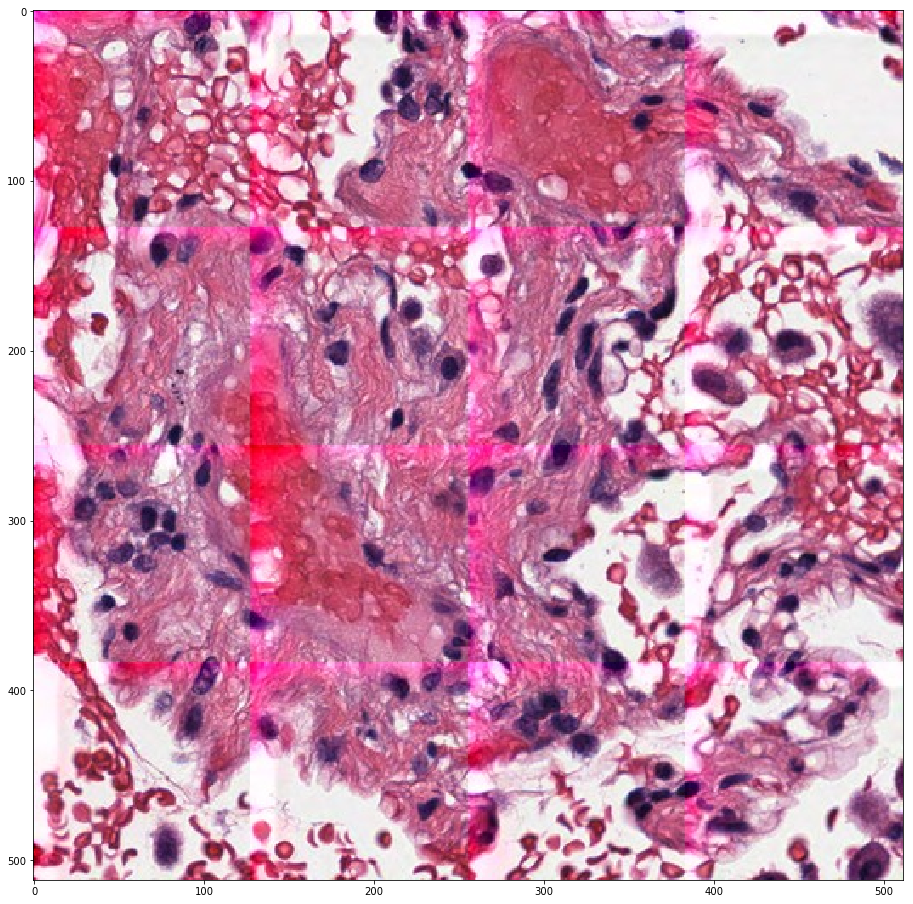

In [8]:
fig = figure(figsize = (16,16))
imshow(img2)
fig.savefig('/scratch/sb3923/deep-cancer/filter_images/original_'+image_name+'.png', format='png', dpi=1200)


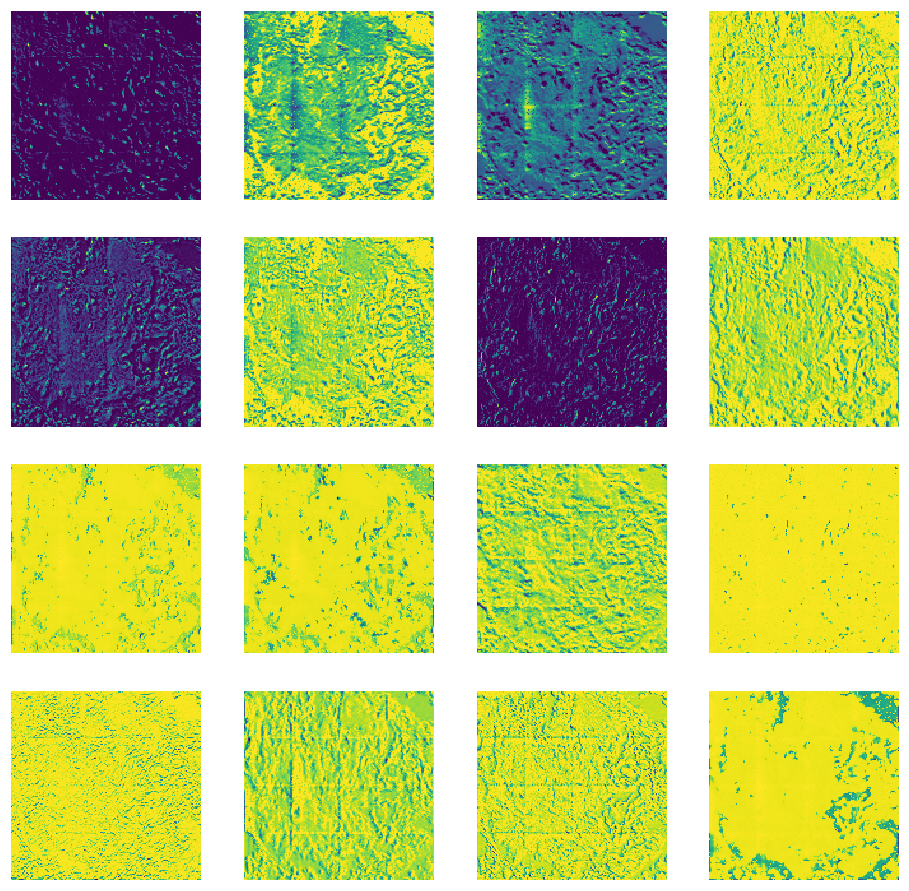

In [9]:
%matplotlib inline

im2 = x1.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(16,16))

for i in range(16):
    ax1 = fig.add_subplot(4,4,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
#plt.subplots_adjust(wspace=0, hspace=0)


fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L1_'+image_name+'.png', format='png', dpi=1200)


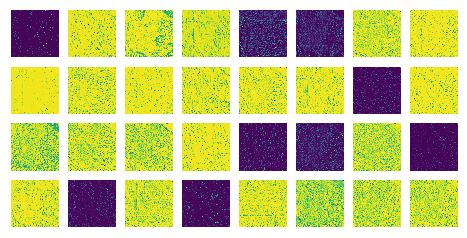

In [10]:
im2 = x2.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(8,4))

for i in range(32):
    ax1 = fig.add_subplot(4,8,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
#plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L2_'+image_name+'.png', format='png', dpi=1200)



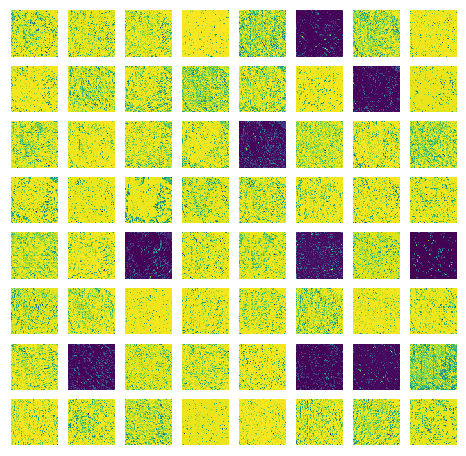

In [11]:
im2 = x3.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax1 = fig.add_subplot(8,8,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

#plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L3_'+image_name+'.png', format='png', dpi=1200)



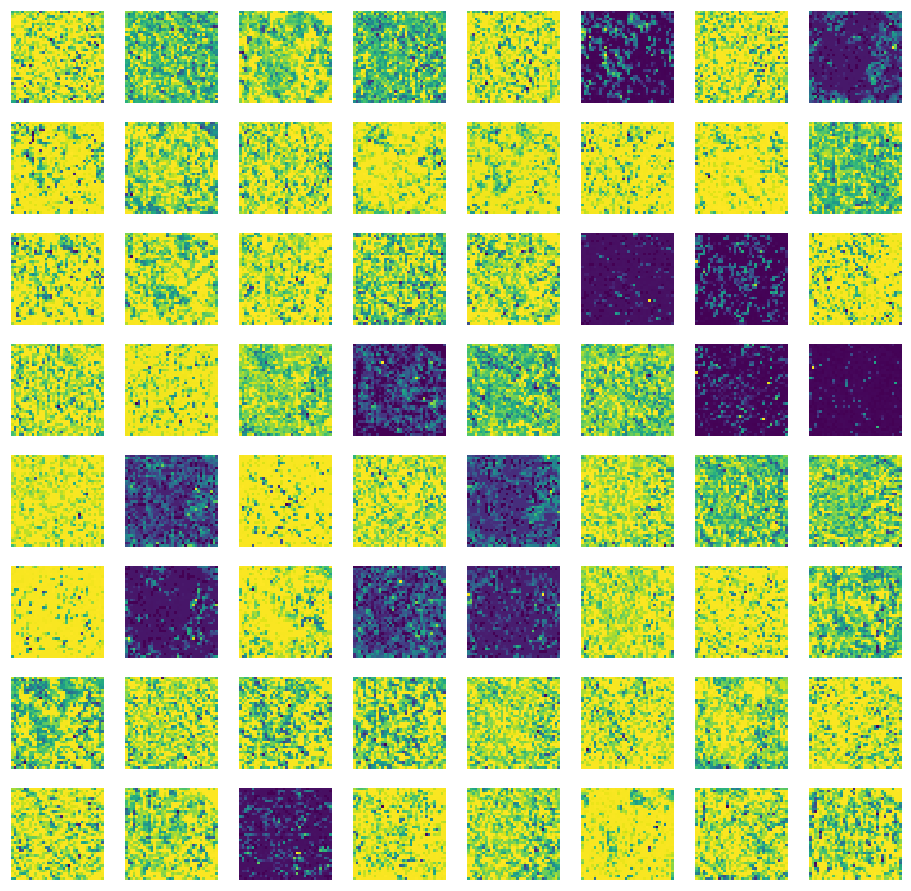

In [12]:
im2 = x4.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(16,16))

for i in range(64):
    ax1 = fig.add_subplot(8,8,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
    
fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L4_'+image_name+'.png', format='png', dpi=1200)


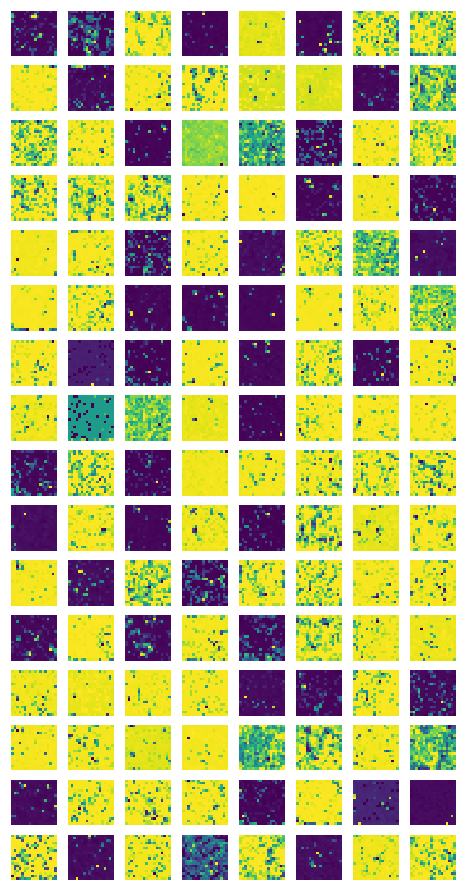

In [13]:
im2 = x5.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(8,16))

for i in range(128):
    ax1 = fig.add_subplot(16,8,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')


    
fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L5_'+image_name+'.png', format='png', dpi=1200)


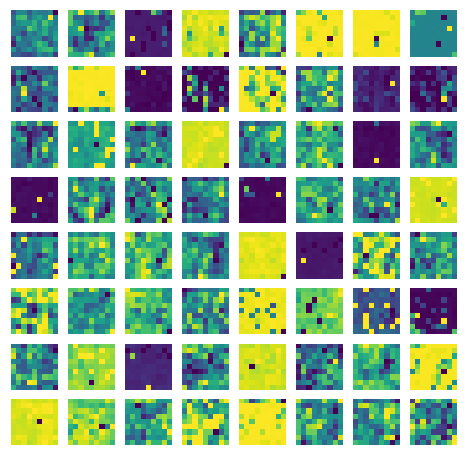

In [14]:
im2 = x6.data.cpu().numpy()
#plt.imshow(im2[0][29])
#plt.show()

fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax1 = fig.add_subplot(8,8,i+1)
    ax1.imshow(im2[0][i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
fig.savefig('/scratch/sb3923/deep-cancer/filter_images/L6_'+image_name+'.png', format='png', dpi=1200)


# first layer filters visualization

In [ ]:
#im3 = numpy.reshape(im2[i], (5, 5, 3)) 

#np.reshape(im2[i%16], (5, 5,3))
fig = plt.figure(figsize=(4,4))

for i in range(16):
    ax1 = fig.add_subplot(4,4,i+1)
    ax1.imshow(im2[i].swapaxes(0,2))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

In [ ]:
#numpy.reshape(im[i], (5, 5, 3))
#im[0]
#im[i].reshape(5,5,3).swapaxes(0,2)
#im[i].swapaxes(0,2)

In [ ]:
#plt.imshow(state_dict['conv4.conv.weight'])

#plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)

#type(state_dict['conv4.conv.weight'])

#pilTrans = state_dict['conv4.conv.weight'].ToTensor()
#plt.imshow(pilTrans[1,:])

#image = (Variable(state_dict['conv4.conv.weight']).data).cpu().numpy()
%pylab inline

im = Variable(state_dict['conv1.conv.weight'])
im2 = im.data.cpu().numpy()
print(im2.shape)


#xarray.plot.imshow()